Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.573357607487814e-05
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3


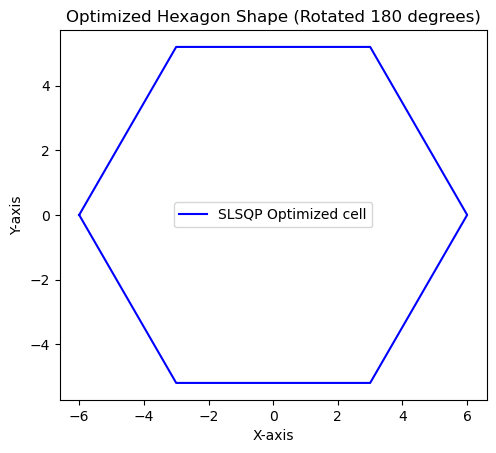

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from honeycomb_analysis import youngs_modulus_E1, youngs_modulus_E2, shear_modulus_G12

# Fixed length of the cell (height of the hexagon)
l = 6.0

# Define weight coefficients
lambda_1 = 0.33
lambda_2 = 0.33
lambda_3 = 0.34

# Ensure the sum of weights is 1
assert lambda_1 + lambda_2 + lambda_3 == 1.0, "The weights should sum to 1."

def objective(H):
    alpha_l, beta_l, theta_deg = H
    try:
        E1 = youngs_modulus_E1(beta_l, l, alpha_l, theta_deg)
        E2 = youngs_modulus_E2(beta_l, l, alpha_l, theta_deg)
        G12 = shear_modulus_G12(beta_l, l, alpha_l, theta_deg)
        
        if np.any(np.isnan([E1, E2, G12])) or np.any(np.isinf([E1, E2, G12])):
            return np.inf  # Return a large value if any modulus is invalid
        
        # Normalize the values to avoid extreme numbers
        E1 /= 1e9
        E2 /= 1e9
        G12 /= 1e9
        
        return -(lambda_1 * E1 + lambda_2 * E2 + lambda_3 * G12)  # Negative for maximization since the optimizer is a minimizer
    except Exception as e:
        print(f"Error in objective function: {e}")
        return np.inf

def constraint_alpha_lower(H):
    alpha_l, beta_l, theta_deg = H
    alpha = alpha_l / l
    return alpha - 0.5

def constraint_alpha_upper(H):
    alpha_l, beta_l, theta_deg = H
    alpha = alpha_l / l
    return 1 - alpha

def constraint_beta_lower(H):
    alpha_l, beta_l, theta_deg = H
    beta = beta_l / l
    return beta - 0.004

def constraint_beta_upper(H):
    alpha_l, beta_l, theta_deg = H
    beta = beta_l / l
    return 0.008 - beta

def constraint_theta_lower(H):
    alpha_l, beta_l, theta_deg = H
    return theta_deg + 30

def constraint_theta_upper(H):
    alpha_l, beta_l, theta_deg = H
    return 30 - theta_deg

def calculate_relative_density(alpha_l, beta_l, theta_deg):
    t = beta_l
    return (2 / np.sqrt(3)) * (t / l) * (1 - (t / (2 * np.sqrt(3) * l)))

def constraint_relative_density(H, rho_ori):
    alpha_l, beta_l, theta_deg = H
    rho_star = calculate_relative_density(alpha_l, beta_l, theta_deg)
    return rho_ori - rho_star

def run_optimization(initial_guess, rho_ori):
    try:
        bounds = [(3.0, 12.0), (0.024, 0.048), (-30, 30)]
        constraints = [
            {'type': 'ineq', 'fun': constraint_alpha_lower},
            {'type': 'ineq', 'fun': constraint_alpha_upper},
            {'type': 'ineq', 'fun': constraint_beta_lower},
            {'type': 'ineq', 'fun': constraint_beta_upper},
            {'type': 'ineq', 'fun': constraint_theta_lower},
            {'type': 'ineq', 'fun': constraint_theta_upper},
            {'type': 'ineq', 'fun': lambda H: constraint_relative_density(H, rho_ori)},
        ]

        solution_slsqp = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints, options={'disp': True})

        return solution_slsqp
    except Exception as e:
        print(f"Error during optimization: {e}")
        return None

def plot_hexagon(ax, alpha_l, beta_l, theta_deg, color, linestyle, label):
    theta_rad = np.radians(theta_deg)
    h = alpha_l
    t = beta_l

    # Regular hexagon vertices calculation
    x = l * np.cos(np.linspace(0, 2 * np.pi, 7))
    y = l * np.sin(np.linspace(0, 2 * np.pi, 7))

    # Rotate the hexagon 180 degrees
    x = -x
    y = -y

    ax.plot(x, y, color=color, linestyle=linestyle, label=label)

def plot_results(solution_slsqp):
    fig, ax = plt.subplots()
    
    if solution_slsqp.success:
        plot_hexagon(ax, *solution_slsqp.x, 'b', '-', 'SLSQP Optimized cell')
        
    ax.set_aspect('equal')
    ax.legend()
    plt.title("Optimized Hexagon Shape (Rotated 180 degrees)")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

# Initial guesses for optimization
initial_guess = [6.0, 0.04, 30]  # Example initial guess
rho_ori = 0.0153  # Original relative density

solution_slsqp = run_optimization(initial_guess, rho_ori)
plot_results(solution_slsqp)
